The following dataset is containing rhombus and squares. Please segment the image such, that you know for every pixel, if it belongs to a rhombus, square, or background. You can find a tutorial on image segmenation here:

http://blog.qure.ai/notes/semantic-segmentation-deep-learning-review

Best, use the SegNet approach (also see: https://arxiv.org/abs/1511.00561). You can also use other approaches, if you whish.

# Libraries

In [1]:
from __future__ import division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential

model = Sequential()


from keras.layers import Dense,Conv2D,MaxPooling2D,MaxPooling1D

Using TensorFlow backend.


# Create Data

The input images have size 32x32. Each image contains exactly one square and one circle. On top of that, gaussian noise has been added. The output images are a segmentation. For each pixel, there are 3 outputs (4th dimension). The segmentations are encoded as follows:

-) [1,0,0]            Background

-) [0,1,0]            Rhombus

-) [0,0,1]            Square

In [5]:
# Define total number of samples
tot_number_samples = 10000

# Dimension of the images
dim_image = 32

# Object size
obj_size = 5

# Create a dataset randomly and calculate the necessary labels
X = np.zeros((tot_number_samples,dim_image,dim_image,1),dtype=np.double)
y = np.zeros((tot_number_samples,dim_image,dim_image,3),dtype=np.bool)

# Add to every image a square and a circle
for i in range(tot_number_samples):
    # Give current status
    print("\rProgress: {:.1f}%".format(100.*i/tot_number_samples), end='')
    
    # Find the locations of the circle and square, which do not overlap with each other
    x_circle = random.randint(obj_size,dim_image-1-obj_size)
    y_circle = random.randint(obj_size,dim_image-1-obj_size)
    x_square = random.randint(obj_size,dim_image-1-obj_size)
    y_square = random.randint(obj_size,dim_image-1-obj_size)
    while math.fabs(x_circle-x_square) <= 2*obj_size and math.fabs(y_circle-y_square) <= 2*obj_size:
        x_circle = random.randint(obj_size,dim_image-1-obj_size)
        y_circle = random.randint(obj_size,dim_image-1-obj_size)
        x_square = random.randint(obj_size,dim_image-1-obj_size)
        y_square = random.randint(obj_size,dim_image-1-obj_size)
    
    # Decide for each pixel, if it is part of the circle/square or not 
    for xi in range(dim_image):
        for yi in range(dim_image):
            if math.fabs(xi-x_square)<=obj_size and math.fabs(yi-y_square)<=obj_size: # Part of square
                X[i,xi,yi,0] = 1
                y[i,xi,yi,2] = True
            elif math.fabs(xi-x_circle)+math.fabs(yi-y_circle) <= obj_size: # Part of rhombus
                X[i,xi,yi,0] = 1
                y[i,xi,yi,1] = True
            else:
                y[i,xi,yi,0] = True
    
# Add noise
X = np.random.normal(X,1./3)

# Divide the dataset into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) #25 % of data is in test set

del X
del y

Progress: 100.0%

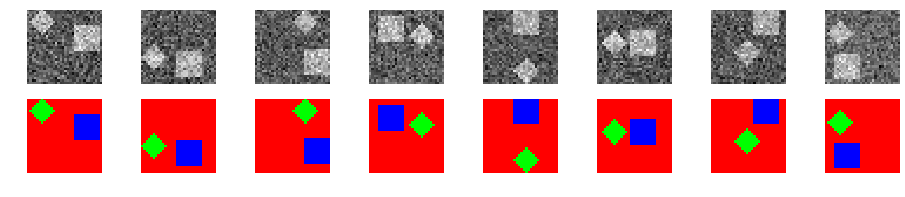

In [6]:
# Plot the first few images (code from: https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb)

n_samples = 8

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(2, n_samples, index + 1)
    plt.imshow(X_train[index,:,:,0], cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, n_samples, index + 1 + n_samples)
    plt.imshow(y_train[index,:,:,:].astype(np.double))
    plt.axis("off")

plt.show()

In [7]:
X_train.shape

(7500, 32, 32, 1)

# Implement The Model

In [21]:
# Put code here
#a_1     = tf.layers.dense(X*X,8,activation=tf.nn.relu,name="hidden_layer_1")
#a_2     = tf.layers.dense(a_1,8,activation=tf.nn.relu,name="hidden_layer_2")
#a_3     = tf.layers.dense(a_2,1,activation=tf.nn.tanh,name="output")

#y_pred  = tf.squeeze(a_3,1)
# Labels
y = tf.placeholder(shape=[128,32,32,3], dtype=tf.float32, name="y") # Define y with tf.placeholder

# Input layer
X = tf.placeholder("float", shape=[None,32,32,1]) # Define y with tf.placeholder

conv1 = tf.layers.conv2d(inputs=X,
                         filters=20,
                         kernel_size=[5, 5],
                         data_format='channels_last',
                         padding="same",
                         activation=tf.nn.relu,
                         use_bias=True,
                         kernel_initializer=None,
                         bias_initializer=tf.zeros_initializer(),
                         kernel_regularizer=None)

conv2 = tf.layers.conv2d(inputs=conv1,
                         filters=20,
                         kernel_size=[5, 5],
                         data_format='channels_last',
                         padding="same",
                         activation=tf.nn.relu,
                         use_bias=True,
                         kernel_initializer=None,
                         bias_initializer=tf.zeros_initializer(),
                         kernel_regularizer=None)

  # Pooling Layer #1
  # Input Tensor Shape: [batch_size, 32, 32, 20]
  # Output Tensor Shape: [batch_size, 16, 16, 20]
pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#unpsampling
unp1 = tf.image.resize_nearest_neighbor(pool1, (2*16,2*16))

unconv1=tf.layers.conv2d_transpose(
    unp1,
    filters=10,
    kernel_size=[4, 4],
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation=tf.nn.relu,
    use_bias=True,
    kernel_initializer=None,
    bias_initializer=tf.zeros_initializer())
unconv2=tf.layers.conv2d_transpose(
    unconv1,
    filters=1,
    kernel_size=[4, 4],
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation=tf.nn.relu,
    use_bias=True,
    kernel_initializer=None,
    bias_initializer=tf.zeros_initializer())

y_pred=tf.nn.softmax(unconv2)
  # Convolutional Layer #2
  # Input Tensor Shape: [batch_size, 16, 16, 20]
  # Output Tensor Shape: [batch_size, 16, 16, 50]
#conv2 = tf.layers.conv2d(
 #     inputs=pool1,
#      filters=50,
 #     kernel_size=[3, 3],
  #    padding="same",
   #   activation=tf.nn.relu)

  # Pooling Layer #2
  # Input Tensor Shape: [batch_size, 16, 16, 50]
  # Output Tensor Shape: [batch_size, 8, 8, 50]
#pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)



In [22]:
y_pred


<tf.Tensor 'Softmax_3:0' shape=(?, 32, 32, 1) dtype=float32>

# Train the Model

In [23]:
# Put code here 
loss               = tf.reduce_mean((y_pred-y)*(y_pred-y),name="loss" ) # Create a good loss function

y_pred_group       = tf.cast(y_pred>0.5,dtype=tf.float32,name="y_pred_group")
correct            = tf.equal(y_pred_group*2-1,y, name="correct")
#accuracy           = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
accuracy           = tf.cast(correct, tf.float32, name="accuracy")

#accuracy           = tf.metrics.accuracy(y_train,y)
                                
optimizer          = tf.train.AdamOptimizer()
training_optimizer = optimizer.minimize(loss, name="training_optimizer")

init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [24]:
n_epochs                = 100
batch_size              = 128

n_iterations_per_epoch  = y_train.shape[0] // batch_size
n_iterations_validation = y_test.shape[0] // batch_size
best_loss_val           = np.infty

checkpoint_path = "./Task_3_network"

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(n_iterations_per_epoch):
            X_batch = X_train[iteration*batch_size:(iteration+1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration+1)*batch_size]
            
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_optimizer, loss],
                feed_dict={X:X_batch, y: y_batch })

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(n_iterations_validation):
            X_batch = X_test[iteration*batch_size:(iteration+1)*batch_size,:]
            y_batch = y_test[iteration*batch_size:(iteration+1)*batch_size]
            loss_val, acc_val = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch,y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch+1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 33.3333%  Loss: 0.666667 (improved)
Epoch: 2  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 3  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 4  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 5  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 6  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 7  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 8  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 9  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 10  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 11  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 12  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 13  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 14  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 15  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 16  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 17  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 18  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 19  Val accuracy: 33.3333%  Loss: 0.666667
Epoch: 20  Val accuracy: 33.3333%  Loss: 0.66666